# Imports

In [6]:
# Cell 1 — Imports
import pandas as pd
from calendar import monthrange
from pulp import (
    LpProblem, LpMinimize, LpVariable, LpStatus, lpSum, value
)

# Config 

In [7]:
# Cell 2 — Config / Inputs (edit these)

# Months (1..12). You can change this to any list of months you model.
months = list(range(1, 13))

# Target power (MW) required EACH month (can be constant or month-by-month)
T_MW = {m: 30 for m in months}  # e.g., 150 MW every month
# Example of varying target:
# T_MW = {1:140, 2:140, 3:145, 4:150, 5:155, 6:160, 7:160, 8:160, 9:155, 10:150, 11:145, 12:140}

# Supplies (1..N) — name them however you like
supplies = ["solar_base", "solar_surplus", "solar_excess", "diesel", "grid"]

# Tariff in USD per MWh for each supply
tariff_usd_per_mwh = {
    "grid": 110,
    "diesel": 500,
    "solar_base": 165,
    "solar_surplus": 165,
    "solar_excess": 190,
}

# x bounds (usage factor) per supply: 0..1 typically, but you can set min/max
x_min = {"grid": 1.0, "diesel": 0.0, "solar_base": 1.0, "solar_surplus": 1.0, "solar_excess": 1.0}
x_max = {"grid": 1.0, "diesel": 1.0, "solar_base": 1.0, "solar_surplus": 1.0, "solar_excess": 1.0}

# Val (MW) per month: can be provided per supply as:
# - a dict {month: val_mw} OR
# - a single number meaning constant across all months.
#
# Interpretation: power output in month m from supply n is:  P[n,m] = x[n,m] * Val[n,m]
Val_input = {
    "grid": 0,  # constant 180 MW available each month
    "diesel": 50, # constant 80 MW
    "solar_base": {n: 28 for n in months},  # constant 50 MW
    "solar_surplus": {    # solar varies by month (example)
        1: 0, 2: 0, 3: 0, 4: 20, 5: 20, 6: 20,
        7: 20, 8: 20, 9: 20, 10: 0, 11: 0, 12: 0
    },
    "solar_excess": {    # solar varies by month (example)
        1: 0, 2: 0, 3: 0, 4: 0, 5: 10, 6: 10,
        7: 10, 8: 5, 9: 0, 10: 0, 11: 0, 12: 0
    }
}

# Choose a year for hours-per-month conversion (leap-year matters for Feb)
year_for_hours = 2026


def hours_in_month(year: int, month: int) -> int:
    return monthrange(year, month)[1] * 24


# Build a complete Val[n,m] table (fills missing with constant if needed)
Val = {}
for n in supplies:
    v = Val_input.get(n, None)
    if v is None:
        raise ValueError(f"Missing Val_input for supply '{n}'. Provide dict by month or a constant number.")
    if isinstance(v, (int, float)):
        Val[n] = {m: float(v) for m in months}
    elif isinstance(v, dict):
        # If some months are missing, assume the first provided value applies to all missing months
        if len(v) == 0:
            raise ValueError(f"Val_input['{n}'] is an empty dict.")
        default_val = float(next(iter(v.values())))
        Val[n] = {m: float(v.get(m, default_val)) for m in months}
    else:
        raise TypeError(f"Val_input['{n}'] must be a number or dict[month->MW]. Got: {type(v)}")

# Precompute monthly hours
H = {m: hours_in_month(year_for_hours, m) for m in months}

# Quick sanity checks
for n in supplies:
    if n not in tariff_usd_per_mwh:
        raise ValueError(f"Missing tariff for '{n}'")
    if n not in x_min or n not in x_max:
        raise ValueError(f"Missing x_min/x_max for '{n}'")
    if x_min[n] > x_max[n]:
        raise ValueError(f"x_min > x_max for '{n}'")

# Model

In [8]:
# Cell 3 — Model (PuLP) + Solve + Results  [REWRITE WITH FIX]

# Create optimization model
model = LpProblem("Monthly_Power_Supply_Cost_Minimization", LpMinimize)

# Decision variables: x[n,m] in [x_min[n], x_max[n]]
x = {
    (n, m): LpVariable(f"x_{n}_{m}", lowBound=x_min[n], upBound=x_max[n])
    for n in supplies for m in months
}

# Objective: minimize total cost = sum_{n,m} (Energy_MWh[n,m] * tariff[n])
# Energy_MWh = (Power_MW = x*Val) * Hours_in_month
model += lpSum(
    (x[(n, m)] * Val[n][m] * H[m]) * tariff_usd_per_mwh[n]
    for n in supplies for m in months
), "Total_Cost_USD"

# Constraints: for each month, total supplied power >= target power
for m in months:
    model += (
        lpSum(x[(n, m)] * Val[n][m] for n in supplies) >= T_MW[m],
        f"TargetPower_Month_{m}"
    )

# Solve (PuLP uses whatever solver is available/configured)
_ = model.solve()

# Basic solve info
status_str = LpStatus[model.status]
print("Status:", status_str)
print("Total cost (USD):", round(value(model.objective), 2))

# Guard: if not optimal, stop here (prevents None values downstream)
if status_str != "Optimal":
    raise RuntimeError(
        f"Optimization did not solve to Optimal. Status={status_str}. "
        "Check feasibility, bounds, and targets."
    )

# Build detailed results table
rows = []
for m in months:
    for n in supplies:
        # Robust value extraction (fix for None issues)
        xn = value(x[(n, m)])
        if xn is None:
            xn = 0.0

        p_mw = xn * Val[n][m]                     # MW
        e_mwh = p_mw * H[m]                       # MWh
        c_usd = e_mwh * tariff_usd_per_mwh[n]     # USD

        rows.append({
            "month": m,
            "supply": n,
            "x": xn,
            "Val_MW": Val[n][m],
            "Power_MW": p_mw,
            "Hours": H[m],
            "Energy_MWh": e_mwh,
            "Tariff_USD_per_MWh": tariff_usd_per_mwh[n],
            "Cost_USD": c_usd,
        })

df = pd.DataFrame(rows)

# Monthly summary
summary = (
    df.groupby("month", as_index=False)
      .agg(
          Target_MW=("month", lambda s: T_MW[int(s.iloc[0])]),
          TotalPower_MW=("Power_MW", "sum"),
          TotalEnergy_MWh=("Energy_MWh", "sum"),
          TotalCost_USD=("Cost_USD", "sum"),
      )
)

display(summary)
display(df)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/lg/9d7bznnx6xsbdtqgfsdbx0g40000gn/T/d0071757652b443592d5fe67278ef36f-pulp.lp
 -o /var/folders/lg/9d7bznnx6xsbdtqgfsdbx0g40000gn/T/d0071757652b443592d5fe67278ef36f-pulp.sol
Reading problem data from '/var/folders/lg/9d7bznnx6xsbdtqgfsdbx0g40000gn/T/d0071757652b443592d5fe67278ef36f-pulp.lp'...
12 rows, 34 columns, 34 non-zeros
71 lines were read
GLPK Simplex Optimizer 5.0
12 rows, 34 columns, 34 non-zeros
Preprocessing...
~     0: obj =   6.423480000e+07  infeas =  0.000e+00
OPTIMAL SOLUTION FOUND BY LP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.0 Mb (40557 bytes)
Writing basic solution to '/var/folders/lg/9d7bznnx6xsbdtqgfsdbx0g40000gn/T/d0071757652b443592d5fe67278ef36f-pulp.sol'...
Status: Optimal
Total cost (USD): 64234800.0


,month,Target_MW,TotalPower_MW,TotalEnergy_MWh,TotalCost_USD
0,1,30,30.0,22320.0,4181280.0
1,2,30,30.0,20160.0,3776640.0
2,3,30,30.0,22320.0,4181280.0
3,4,30,48.0,34560.0,5702400.0
4,5,30,58.0,43152.0,7306080.0
5,6,30,58.0,41760.0,7070400.0
6,7,30,58.0,43152.0,7306080.0
7,8,30,53.0,39432.0,6599280.0
8,9,30,48.0,34560.0,5702400.0
9,10,30,30.0,22320.0,4181280.0


,month,supply,x,Val_MW,Power_MW,Hours,Energy_MWh,Tariff_USD_per_MWh,Cost_USD
0,1,solar_base,1.00,28.0,28.0,744,20832.0,165,3437280.0
1,1,solar_surplus,0.00,0.0,0.0,744,0.0,165,0.0
2,1,solar_excess,0.00,0.0,0.0,744,0.0,190,0.0
3,1,diesel,0.04,50.0,2.0,744,1488.0,500,744000.0
4,1,grid,0.00,0.0,0.0,744,0.0,110,0.0
5,2,solar_base,1.00,28.0,28.0,672,18816.0,165,3104640.0
6,2,solar_surplus,0.00,0.0,0.0,672,0.0,165,0.0
7,2,solar_excess,0.00,0.0,0.0,672,0.0,190,0.0
8,2,diesel,0.04,50.0,2.0,672,1344.0,500,672000.0
9,2,grid,0.00,0.0,0.0,672,0.0,110,0.0


# Overall Cost of Energy

In [12]:
# Cell 4 — Overall cost of energy (USD/MWh) + MW by supply (tables)
# Run AFTER Cell 3

import pandas as pd
import numpy as np

# ================================
# Table 1 — Overall cost of energy
# ================================

monthly_cost_energy = (
    df.groupby("month", as_index=False)
      .agg(
          TotalEnergy_MWh=("Energy_MWh", "sum"),
          TotalCost_USD=("Cost_USD", "sum"),
      )
)

monthly_cost_energy["Cost_USD_per_MWh"] = (
    monthly_cost_energy["TotalCost_USD"] /
    monthly_cost_energy["TotalEnergy_MWh"]
)

monthly_cost_energy["Cost_USD_per_MWh"] = (
    monthly_cost_energy["Cost_USD_per_MWh"]
    .replace([np.inf, -np.inf], np.nan)
    .round(2)
)

monthly_cost_energy["Target_MW"] = monthly_cost_energy["month"].map(T_MW)
monthly_cost_energy["TargetEnergy_MWh"] = (
    monthly_cost_energy["month"].map(H) *
    monthly_cost_energy["Target_MW"]
)

monthly_cost_energy = monthly_cost_energy[
    [
        "month",
        "Target_MW",
        "TargetEnergy_MWh",
        "TotalEnergy_MWh",
        "TotalCost_USD",
        "Cost_USD_per_MWh",
    ]
]

print("=== Overall blended cost of energy (USD/MWh) ===")
display(monthly_cost_energy)


# ==========================================
# Table 2 — MW used by each supply per month
# ==========================================

mw_by_supply = (
    df.pivot_table(
        index="month",
        columns="supply",
        values="Power_MW",
        aggfunc="sum"
    )
    .fillna(0)
    .round(0)
)

# Add totals and target for reference
mw_by_supply["Total_MW"] = mw_by_supply.sum(axis=1)
mw_by_supply["Target_MW"] = mw_by_supply.index.map(T_MW)
mw_by_supply["Margin_MW"] = mw_by_supply["Total_MW"] - mw_by_supply["Target_MW"]

print("=== MW used by each supply per month ===")
display(mw_by_supply)


# ============================================================================
# Table 3 — Solar energy: available vs used vs unused (curtailed) per month (MWh)
# ============================================================================
# Available solar is computed from the configured monthly capacities (Val) times
# hours in month (H). Used solar comes from the dispatch result df.

solar_supplies = [s for s in ["solar_base", "solar_excess", "solar_surplus"] if s in supplies]
months_index = pd.Index(sorted(months), name="month")

# Available solar energy (MWh) per month (per supply)
solar_available_mwh = pd.DataFrame(
    {s: pd.Series({m: Val[s][m] * H[m] for m in months}, name=s) for s in solar_supplies}
).reindex(months_index).fillna(0)

# Used solar energy (MWh) per month (per supply) from the dispatch result df
solar_used_mwh = (
    df[df["supply"].isin(solar_supplies)]
    .pivot_table(index="month", columns="supply", values="Energy_MWh", aggfunc="sum")
    .reindex(months_index)
    .fillna(0)
)

# Unused (curtailed) solar energy (MWh)
solar_unused_mwh = (solar_available_mwh - solar_used_mwh).clip(lower=0)

# Build a single wide table: Available / Used / Unused per supply
solar_energy_table = pd.DataFrame(index=months_index)

for s in solar_supplies:
    solar_energy_table[f"{s}_Available_MWh"] = solar_available_mwh[s]
    solar_energy_table[f"{s}_Used_MWh"] = solar_used_mwh[s]
    solar_energy_table[f"{s}_Unused_MWh"] = solar_unused_mwh[s]

solar_energy_table["Total_Solar_Available_MWh"] = solar_available_mwh.sum(axis=1)
solar_energy_table["Total_Solar_Used_MWh"] = solar_used_mwh.sum(axis=1)
solar_energy_table["Total_Solar_Unused_MWh"] = solar_unused_mwh.sum(axis=1)

solar_energy_table = solar_energy_table.round(2)

print("=== Solar energy per month (MWh): available vs used vs unused ===")
display(solar_energy_table)

=== Overall blended cost of energy (USD/MWh) ===


,month,Target_MW,TargetEnergy_MWh,TotalEnergy_MWh,TotalCost_USD,Cost_USD_per_MWh
0,1,30,22320,22320.0,4181280.0,187.33
1,2,30,20160,20160.0,3776640.0,187.33
2,3,30,22320,22320.0,4181280.0,187.33
3,4,30,21600,34560.0,5702400.0,165.00
4,5,30,22320,43152.0,7306080.0,169.31
5,6,30,21600,41760.0,7070400.0,169.31
6,7,30,22320,43152.0,7306080.0,169.31
7,8,30,22320,39432.0,6599280.0,167.36
8,9,30,21600,34560.0,5702400.0,165.00
9,10,30,22320,22320.0,4181280.0,187.33


=== MW used by each supply per month ===


supply,diesel,grid,solar_base,solar_excess,solar_surplus,Total_MW,Target_MW,Margin_MW
month,,,,,,,,
1,2.0,0.0,28.0,0.0,0.0,30.0,30,0.0
2,2.0,0.0,28.0,0.0,0.0,30.0,30,0.0
3,2.0,0.0,28.0,0.0,0.0,30.0,30,0.0
4,0.0,0.0,28.0,0.0,20.0,48.0,30,18.0
5,0.0,0.0,28.0,10.0,20.0,58.0,30,28.0
6,0.0,0.0,28.0,10.0,20.0,58.0,30,28.0
7,0.0,0.0,28.0,10.0,20.0,58.0,30,28.0
8,0.0,0.0,28.0,5.0,20.0,53.0,30,23.0
9,0.0,0.0,28.0,0.0,20.0,48.0,30,18.0


=== Solar energy per month (MWh): available vs used vs unused ===


,solar_base_Available_MWh,solar_base_Used_MWh,solar_base_Unused_MWh,solar_excess_Available_MWh,solar_excess_Used_MWh,solar_excess_Unused_MWh,solar_surplus_Available_MWh,solar_surplus_Used_MWh,solar_surplus_Unused_MWh,Total_Solar_Available_MWh,Total_Solar_Used_MWh,Total_Solar_Unused_MWh
month,,,,,,,,,,,,
1,20832.0,20832.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20832.0,20832.0,0.0
2,18816.0,18816.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18816.0,18816.0,0.0
3,20832.0,20832.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20832.0,20832.0,0.0
4,20160.0,20160.0,0.0,0.0,0.0,0.0,14400.0,14400.0,0.0,34560.0,34560.0,0.0
5,20832.0,20832.0,0.0,7440.0,7440.0,0.0,14880.0,14880.0,0.0,43152.0,43152.0,0.0
6,20160.0,20160.0,0.0,7200.0,7200.0,0.0,14400.0,14400.0,0.0,41760.0,41760.0,0.0
7,20832.0,20832.0,0.0,7440.0,7440.0,0.0,14880.0,14880.0,0.0,43152.0,43152.0,0.0
8,20832.0,20832.0,0.0,3720.0,3720.0,0.0,14880.0,14880.0,0.0,39432.0,39432.0,0.0
9,20160.0,20160.0,0.0,0.0,0.0,0.0,14400.0,14400.0,0.0,34560.0,34560.0,0.0


# Plotting

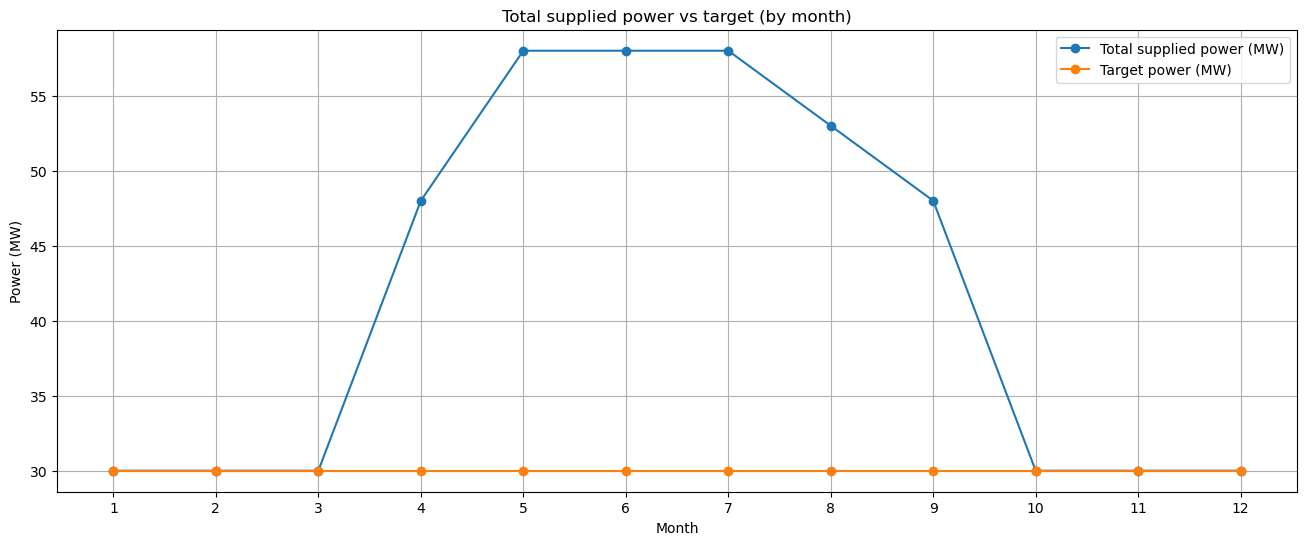

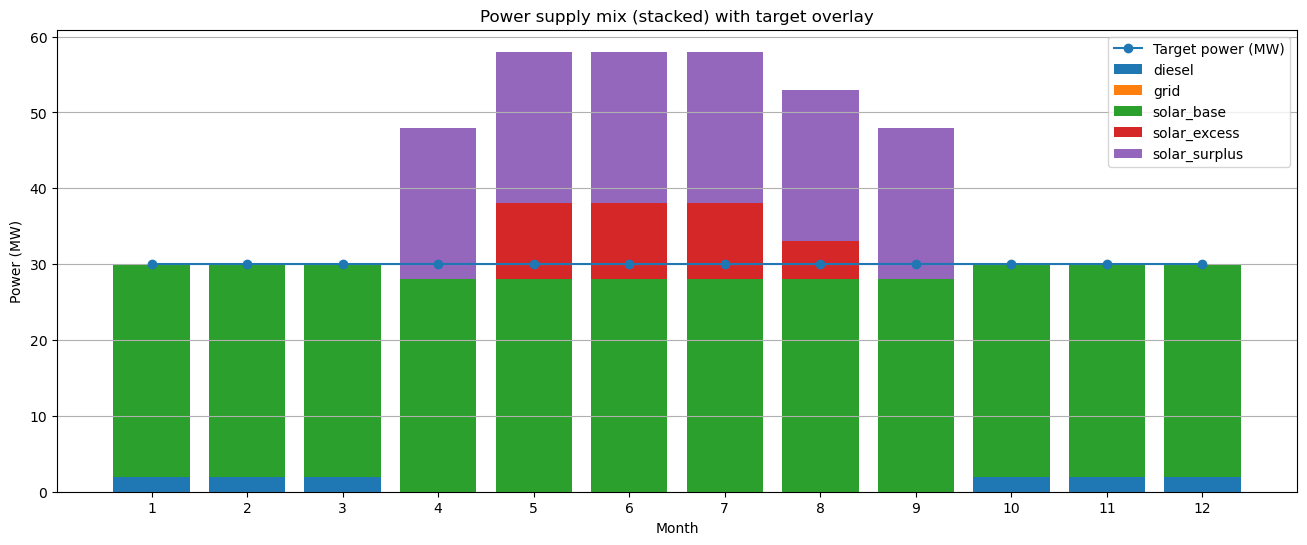

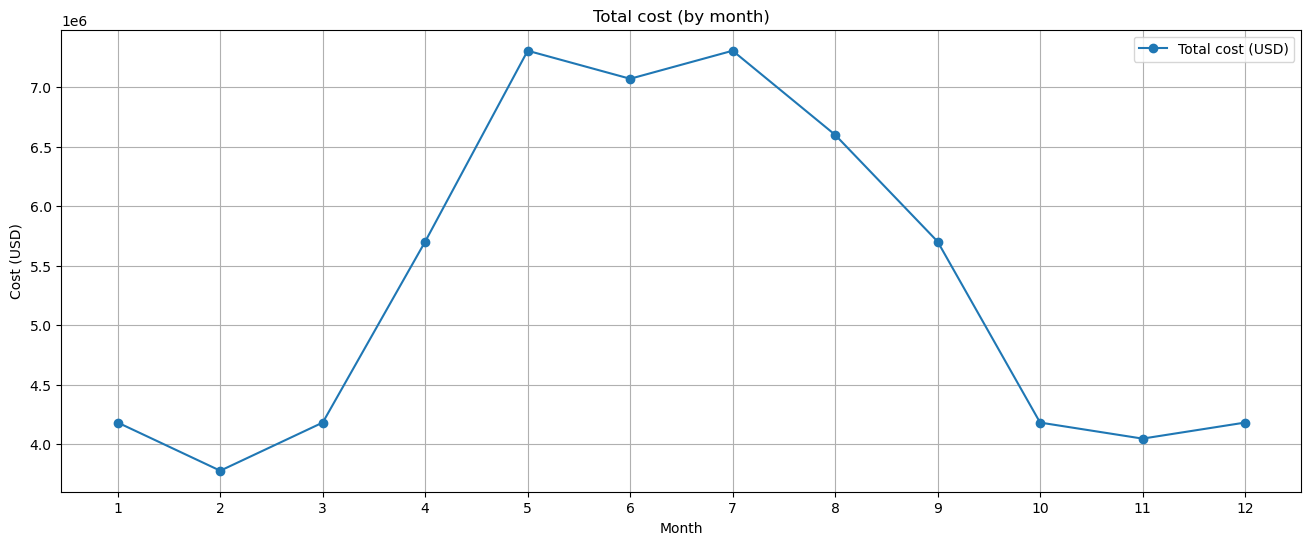

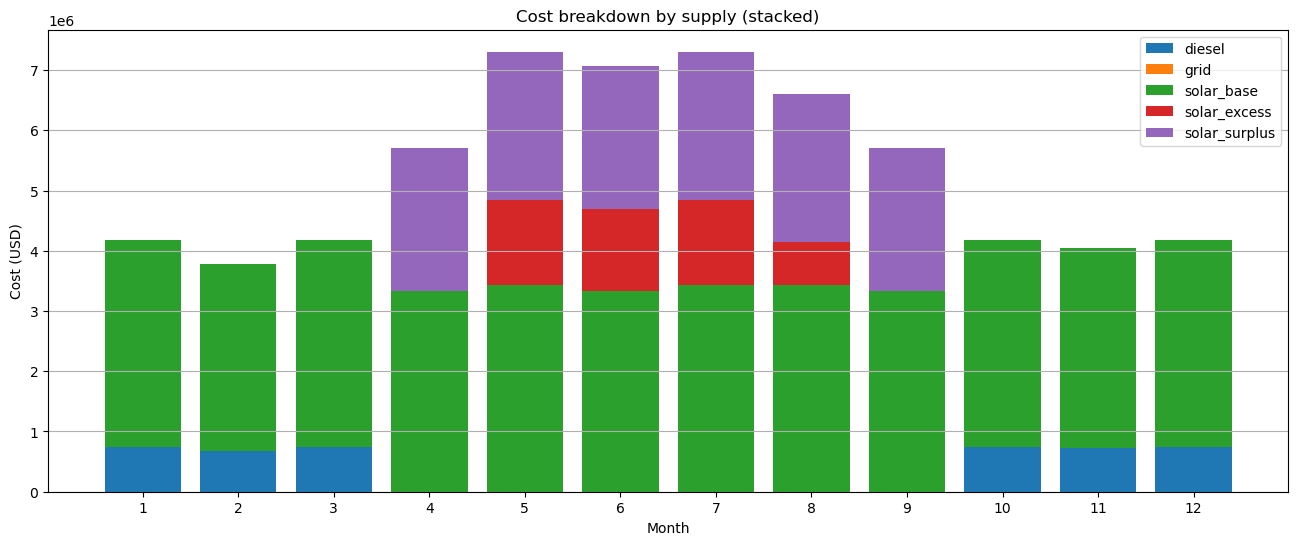

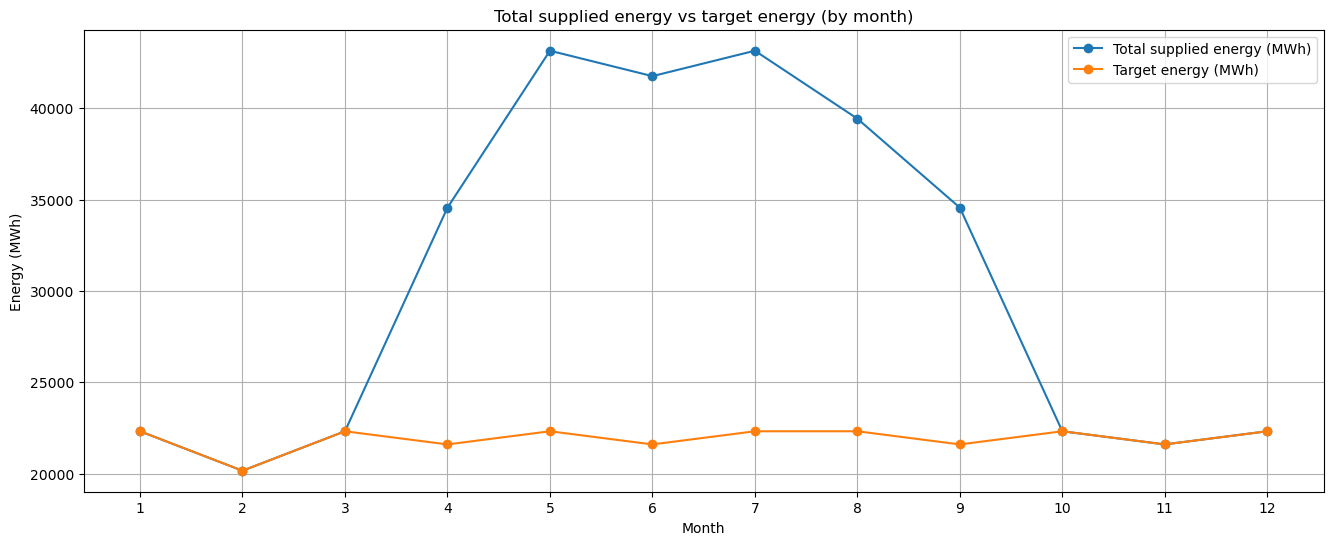

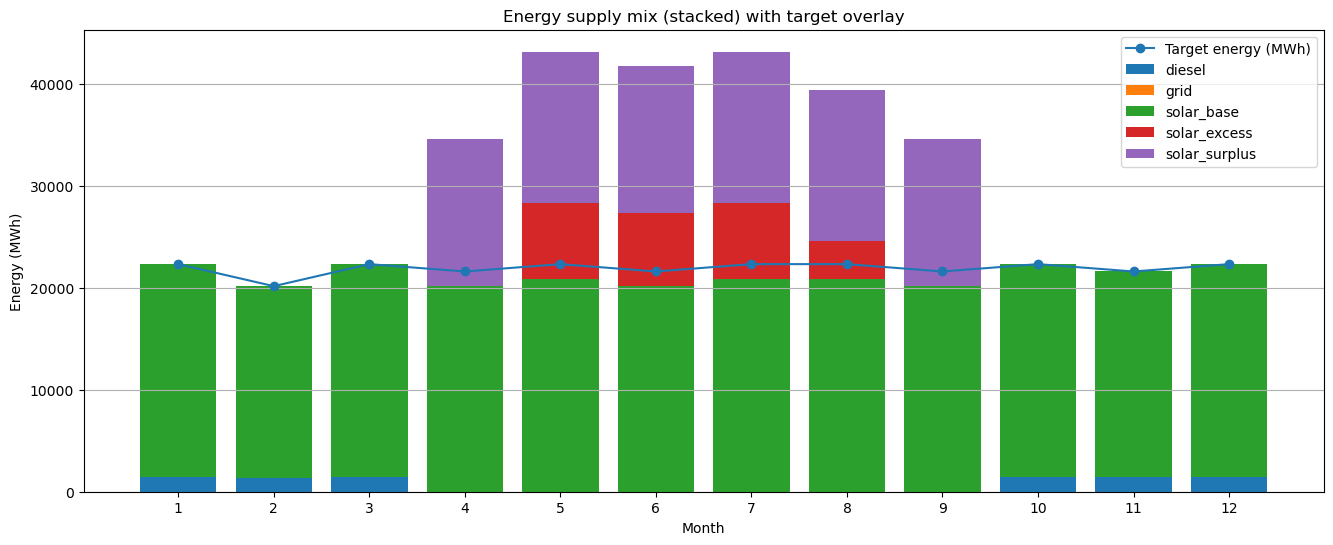

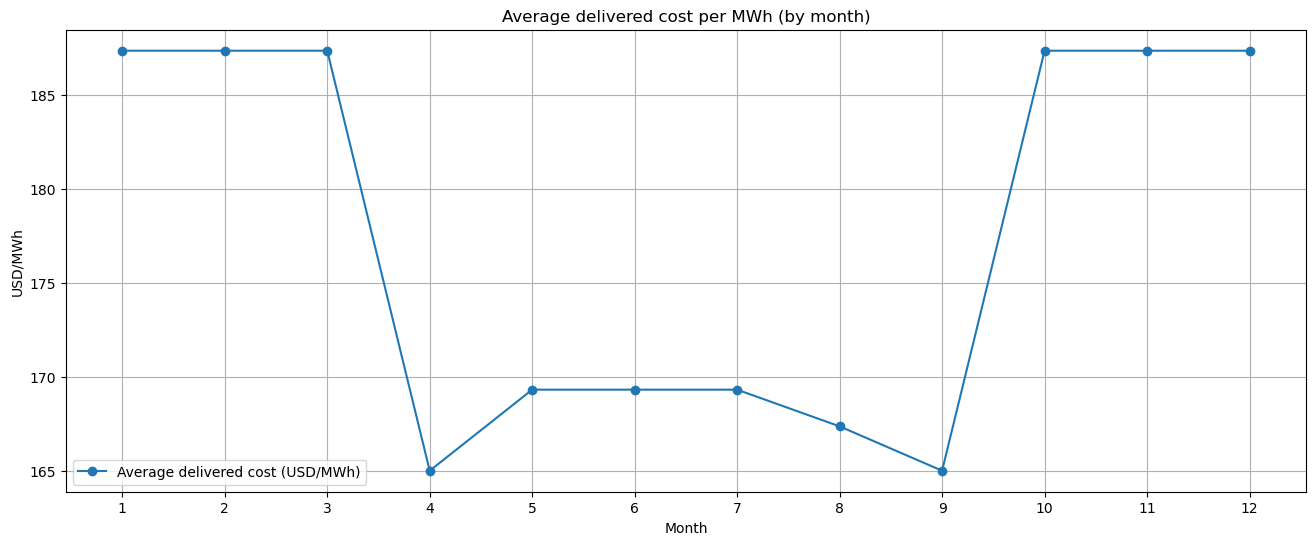

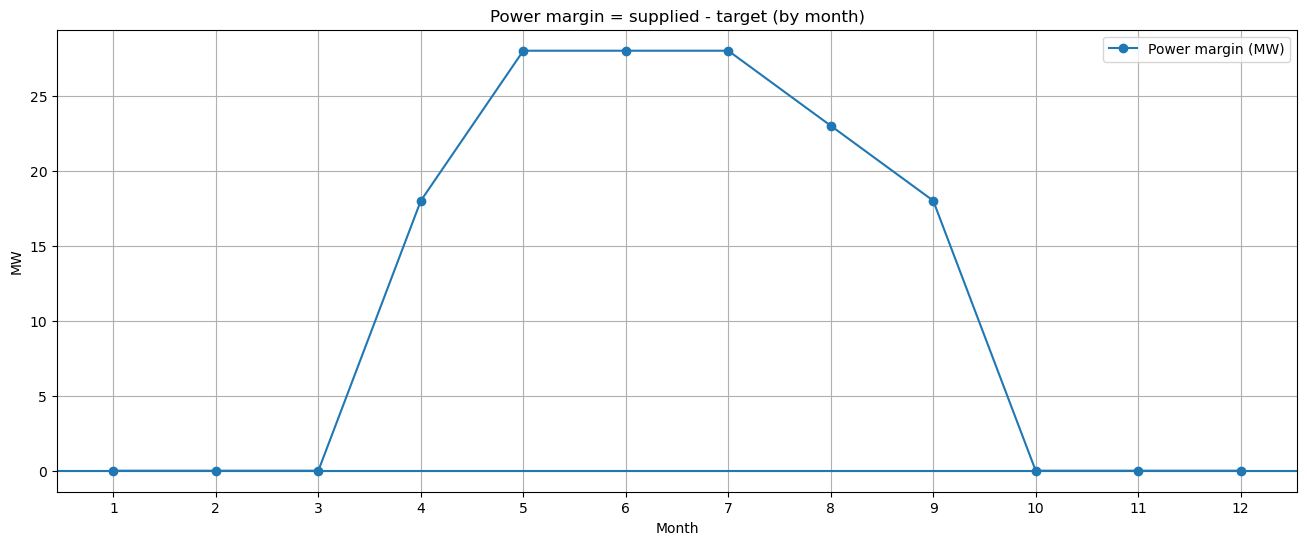

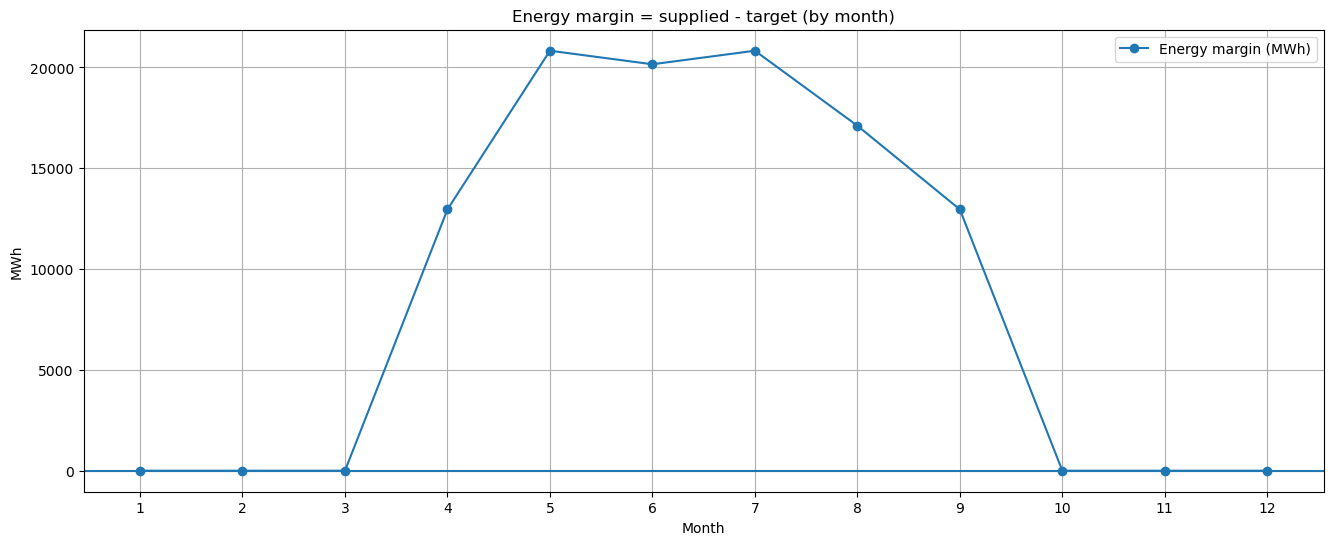

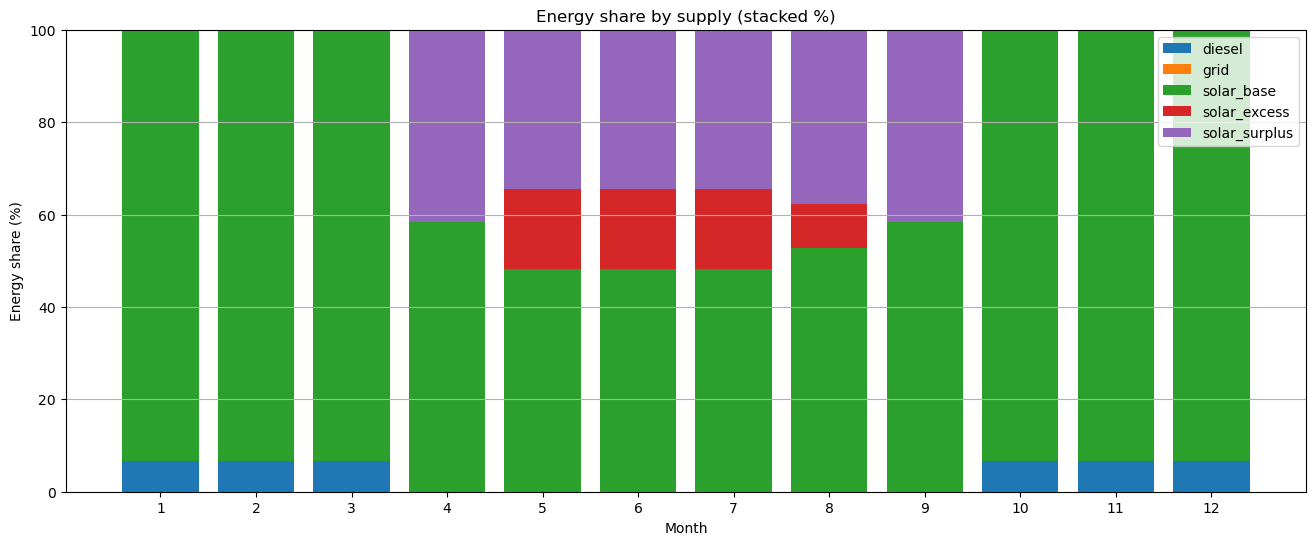

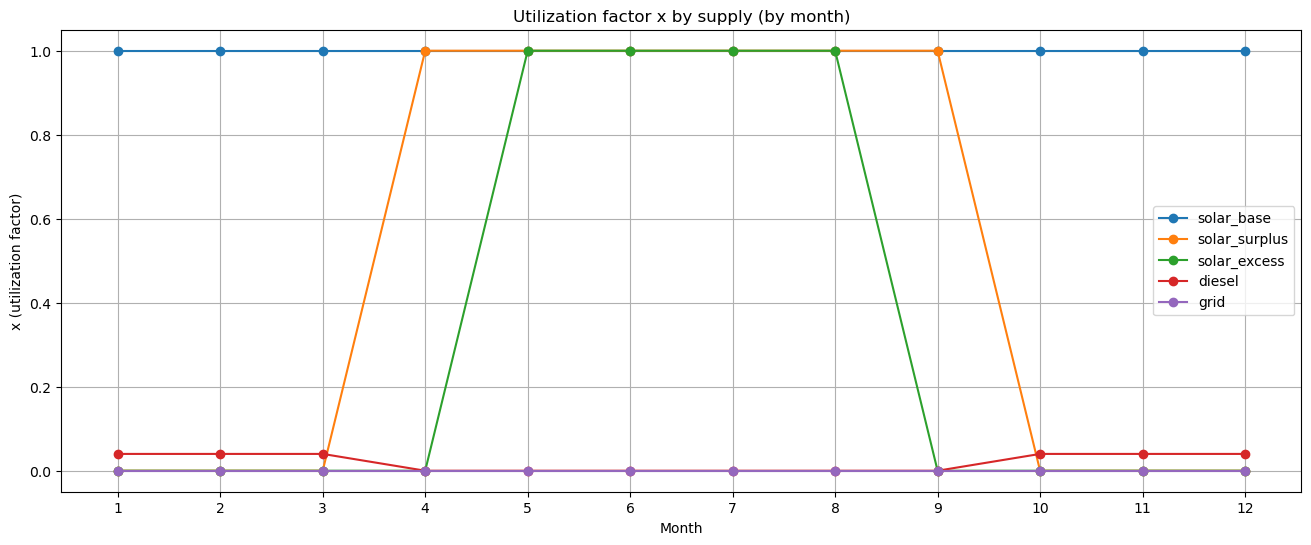

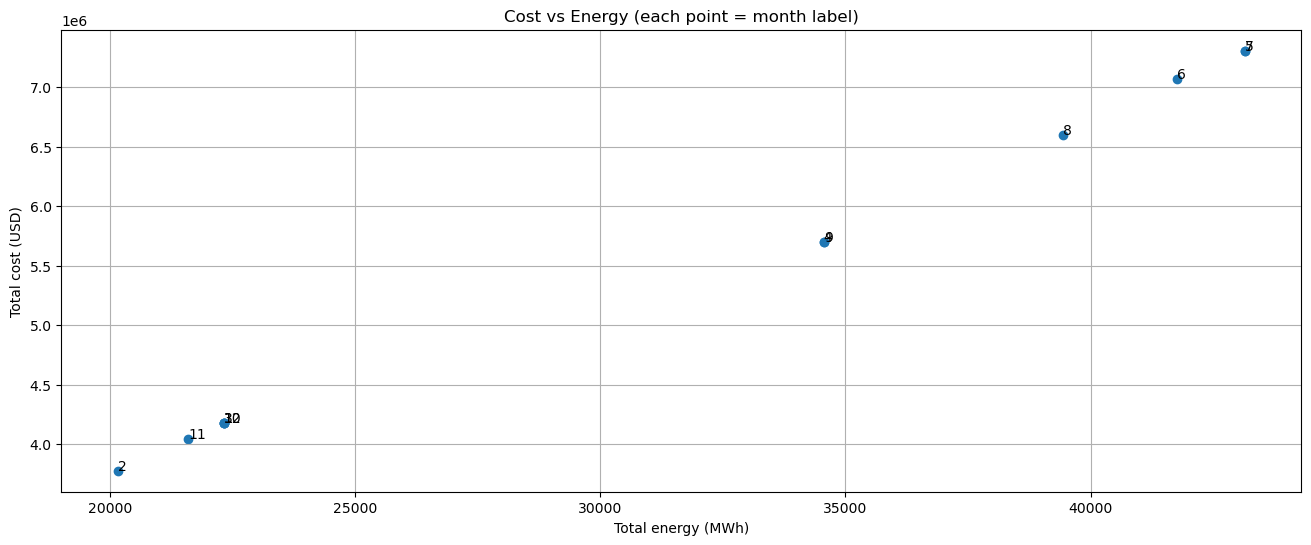

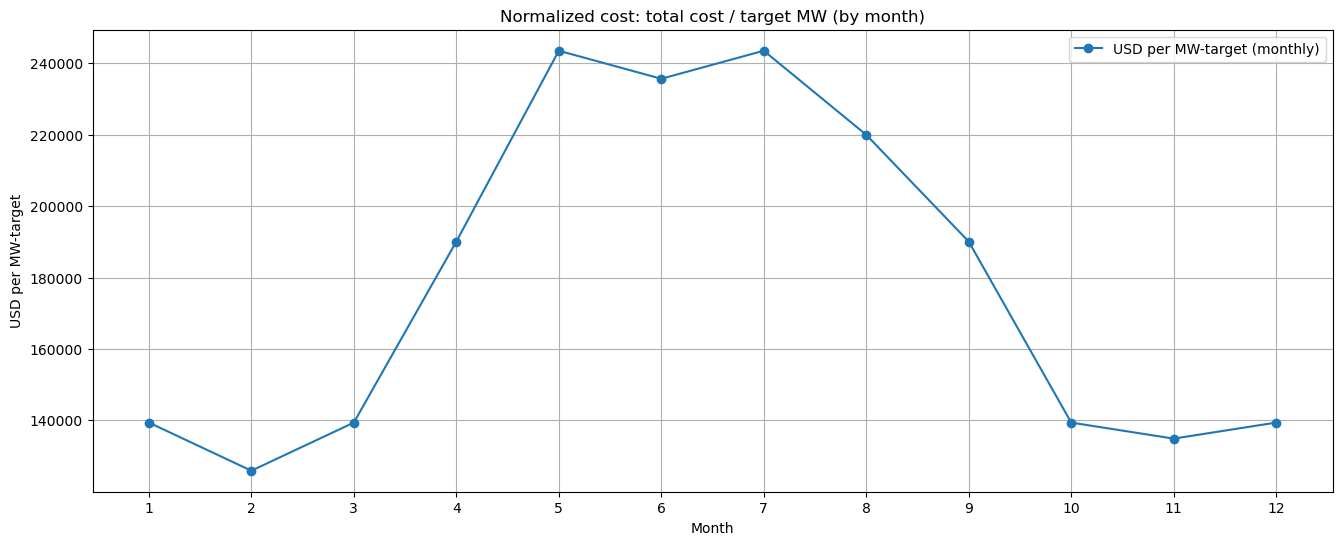

In [ ]:
# Cell 5 — Plots (FULL REWRITE WITH ROBUST value() FIX)
# Run AFTER Cell 3 (requires: df, supplies, T_MW, H, x, months)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulp import value

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 6)   # width, height in inches

# --- Prepare pivots from df ---
power_pivot = df.pivot_table(index="month", columns="supply", values="Power_MW",  aggfunc="sum").fillna(0)
energy_pivot = df.pivot_table(index="month", columns="supply", values="Energy_MWh", aggfunc="sum").fillna(0)
cost_pivot  = df.pivot_table(index="month", columns="supply", values="Cost_USD",   aggfunc="sum").fillna(0)

months_sorted = sorted(df["month"].unique())

target_power  = pd.Series({m: T_MW[m] for m in months_sorted}).sort_index()     # MW
hours_series  = pd.Series({m: H[m] for m in months_sorted}).sort_index()       # hours
target_energy = target_power * hours_series                                     # MWh

total_power  = power_pivot.sum(axis=1).reindex(months_sorted)                   # MW
total_energy = energy_pivot.sum(axis=1).reindex(months_sorted)                  # MWh
total_cost   = cost_pivot.sum(axis=1).reindex(months_sorted)                    # USD

# Helper for stacked bars
def stacked_bar(pivot_df: pd.DataFrame, title: str, ylabel: str, overlay_line=None, overlay_label=None):
    plt.figure()
    bottom = np.zeros(len(months_sorted))
    pivot_df = pivot_df.reindex(months_sorted).fillna(0)

    for col in pivot_df.columns:
        vals = pivot_df[col].values
        plt.bar(months_sorted, vals, bottom=bottom, label=str(col))
        bottom += vals

    if overlay_line is not None:
        plt.plot(months_sorted, overlay_line.reindex(months_sorted).values, marker="o", label=overlay_label)

    plt.xticks(months_sorted)
    plt.xlabel("Month")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, axis="y")
    plt.show()


# 1) Total supplied power vs target power
plt.figure()
plt.plot(months_sorted, total_power.values, marker="o", label="Total supplied power (MW)")
plt.plot(months_sorted, target_power.values, marker="o", label="Target power (MW)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("Power (MW)")
plt.title("Total supplied power vs target (by month)")
plt.legend()
plt.grid(True)
plt.show()

# 1b) Power supply mix (stacked) + target overlay
stacked_bar(
    power_pivot,
    title="Power supply mix (stacked) with target overlay",
    ylabel="Power (MW)",
    overlay_line=target_power,
    overlay_label="Target power (MW)"
)

# 2) Total cost by month
plt.figure()
plt.plot(months_sorted, total_cost.values, marker="o", label="Total cost (USD)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("Cost (USD)")
plt.title("Total cost (by month)")
plt.legend()
plt.grid(True)
plt.show()

# 2b) Cost breakdown by supply (stacked)
stacked_bar(
    cost_pivot,
    title="Cost breakdown by supply (stacked)",
    ylabel="Cost (USD)"
)

# 3) Total supplied energy vs target energy
plt.figure()
plt.plot(months_sorted, total_energy.values, marker="o", label="Total supplied energy (MWh)")
plt.plot(months_sorted, target_energy.values, marker="o", label="Target energy (MWh)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("Energy (MWh)")
plt.title("Total supplied energy vs target energy (by month)")
plt.legend()
plt.grid(True)
plt.show()

# 3b) Energy mix (stacked) + target overlay
stacked_bar(
    energy_pivot,
    title="Energy supply mix (stacked) with target overlay",
    ylabel="Energy (MWh)",
    overlay_line=target_energy,
    overlay_label="Target energy (MWh)"
)

# --- Additional insight plots ---

# A) Average delivered unit cost (USD/MWh) each month
avg_unit_cost = (total_cost / total_energy).replace([np.inf, -np.inf], np.nan)
plt.figure()
plt.plot(months_sorted, avg_unit_cost.values, marker="o", label="Average delivered cost (USD/MWh)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("USD/MWh")
plt.title("Average delivered cost per MWh (by month)")
plt.legend()
plt.grid(True)
plt.show()

# B) Margin above target (MW and MWh)
power_margin  = total_power  - target_power
energy_margin = total_energy - target_energy

plt.figure()
plt.plot(months_sorted, power_margin.values, marker="o", label="Power margin (MW)")
plt.axhline(0)
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("MW")
plt.title("Power margin = supplied - target (by month)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(months_sorted, energy_margin.values, marker="o", label="Energy margin (MWh)")
plt.axhline(0)
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("MWh")
plt.title("Energy margin = supplied - target (by month)")
plt.legend()
plt.grid(True)
plt.show()

# C) Energy share (%) by supply (stacked)
energy_share_pct = energy_pivot.div(energy_pivot.sum(axis=1), axis=0).fillna(0).reindex(months_sorted) * 100.0

plt.figure()
bottom = np.zeros(len(months_sorted))
for s in energy_share_pct.columns:
    vals = energy_share_pct[s].values
    plt.bar(months_sorted, vals, bottom=bottom, label=str(s))
    bottom += vals
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("Energy share (%)")
plt.title("Energy share by supply (stacked %)")
plt.legend()
plt.grid(True, axis="y")
plt.show()

# D) Utilization factor x[n,m] by supply (ROBUST value extraction)
plt.figure()
for s in supplies:
    xs = []
    for m in months_sorted:
        v = value(x[(s, m)])
        xs.append(0.0 if v is None else float(v))
    plt.plot(months_sorted, xs, marker="o", label=str(s))

plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("x (utilization factor)")
plt.title("Utilization factor x by supply (by month)")
plt.legend()
plt.grid(True)
plt.show()

# E) Correlation-style view: Cost vs Energy (by month)
plt.figure()
plt.scatter(total_energy.values, total_cost.values)
for i, m in enumerate(months_sorted):
    plt.annotate(str(m), (total_energy.values[i], total_cost.values[i]))
plt.xlabel("Total energy (MWh)")
plt.ylabel("Total cost (USD)")
plt.title("Cost vs Energy (each point = month label)")
plt.grid(True)
plt.show()

# F) Monthly cost per MW of target (useful normalization)
cost_per_target_mw = total_cost / target_power.replace(0, np.nan)
plt.figure()
plt.plot(months_sorted, cost_per_target_mw.values, marker="o", label="USD per MW-target (monthly)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("USD per MW-target")
plt.title("Normalized cost: total cost / target MW (by month)")
plt.legend()
plt.grid(True)
plt.show()